In [115]:
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix , classification_report, ConfusionMatrixDisplay
import scipy.stats as ss

In [87]:
#cramers function
def cramers_corrected_stat(confusion_matrix):

    """ calculate Cramers V statistic for categorial-categorial association.

        uses correction from Bergsma and Wicher,

        Journal of the Korean Statistical Society 42 (2013): 323-328

    """

    chi2 = ss.chi2_contingency(confusion_matrix)[0]

    n = confusion_matrix.sum()

    phi2 = chi2/n

    r,k = confusion_matrix.shape

    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))  

    rcorr = r - ((r-1)**2)/(n-1)

    kcorr = k - ((k-1)**2)/(n-1)

    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

#### data loading

In [88]:
cardio_df = pd.read_csv('cardio_train.csv' , sep= ';')

#print(cardio_df.head())
#print(cardio_df.describe().T)
print(cardio_df.info())
print(cardio_df.shape)
#print(cardio_df.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70003 entries, 0 to 70002
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70003 non-null  int64  
 1   age          70003 non-null  int64  
 2   gender       70003 non-null  int64  
 3   height       70001 non-null  float64
 4   weight       70002 non-null  float64
 5   ap_hi        70003 non-null  int64  
 6   ap_lo        70003 non-null  int64  
 7   cholesterol  70001 non-null  float64
 8   gluc         70003 non-null  int64  
 9   smoke        70003 non-null  int64  
 10  alco         70002 non-null  float64
 11  active       70003 non-null  int64  
 12  cardio       70003 non-null  int64  
dtypes: float64(4), int64(9)
memory usage: 6.9 MB
None
(70003, 13)


In [89]:
## check for duplicate and null
cardio_df =cardio_df.drop_duplicates()


In [90]:
cardio_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70000 entries, 0 to 70002
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       69998 non-null  float64
 4   weight       69999 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  69998 non-null  float64
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         69999 non-null  float64
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(4), int64(9)
memory usage: 7.5 MB


In [91]:
cardio_df.isna().sum()

id             0
age            0
gender         0
height         2
weight         1
ap_hi          0
ap_lo          0
cholesterol    2
gluc           0
smoke          0
alco           1
active         0
cardio         0
dtype: int64

In [92]:
cardio_df.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,69998.000000,69999.000000,70000.000000,70000.000000,69998.000000,70000.000000,70000.000000,69999.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349571,164.359096,74.205507,128.817286,96.630414,1.366882,1.226457,0.088129,0.053772,0.803729,0.499700
std,28851.302323,2467.251667,0.476838,8.210178,14.395778,154.011419,188.472530,0.680257,0.572270,0.283484,0.225569,0.397179,0.500003
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [93]:
cardio1_df = cardio_df.dropna()



In [94]:
cardio1_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 69994 entries, 0 to 70002
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           69994 non-null  int64  
 1   age          69994 non-null  int64  
 2   gender       69994 non-null  int64  
 3   height       69994 non-null  float64
 4   weight       69994 non-null  float64
 5   ap_hi        69994 non-null  int64  
 6   ap_lo        69994 non-null  int64  
 7   cholesterol  69994 non-null  float64
 8   gluc         69994 non-null  int64  
 9   smoke        69994 non-null  int64  
 10  alco         69994 non-null  float64
 11  active       69994 non-null  int64  
 12  cardio       69994 non-null  int64  
dtypes: float64(4), int64(9)
memory usage: 7.5 MB


<AxesSubplot: >

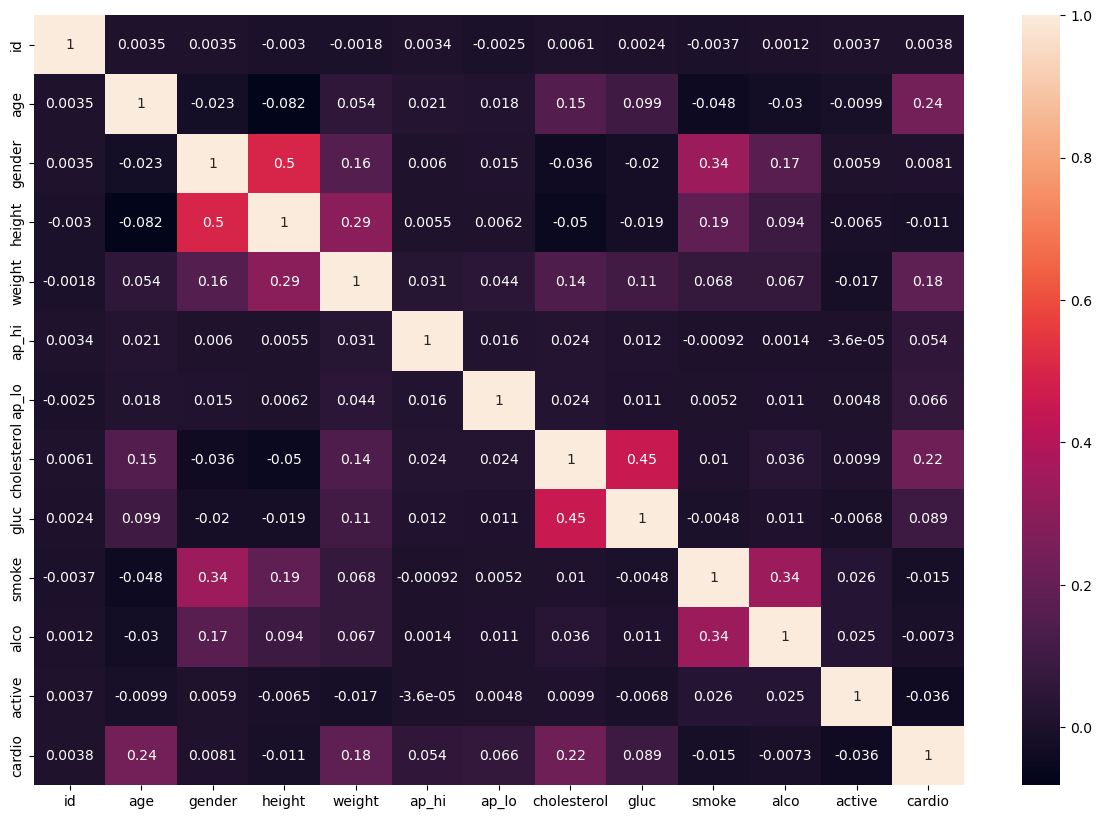

In [95]:
plt.subplots(figsize= (15,10))
sns.heatmap(cardio1_df.corr(), annot = True)

<AxesSubplot: >

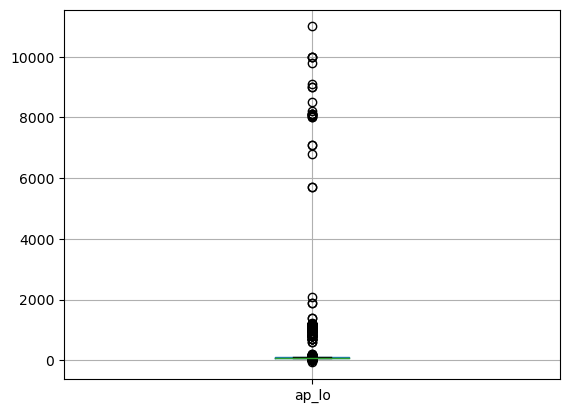

In [96]:
cardio1_df.boxplot(column='ap_lo')


<AxesSubplot: >

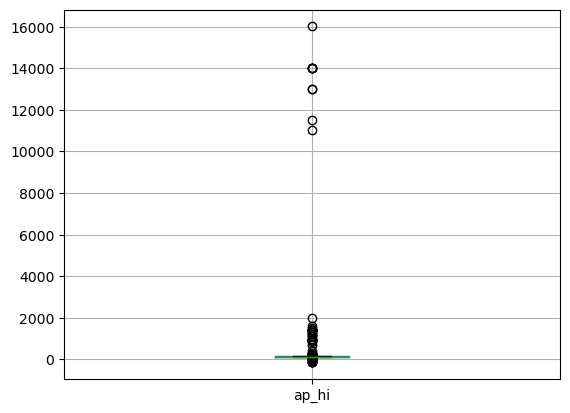

In [97]:
cardio1_df.boxplot(column='ap_hi')

<AxesSubplot: >

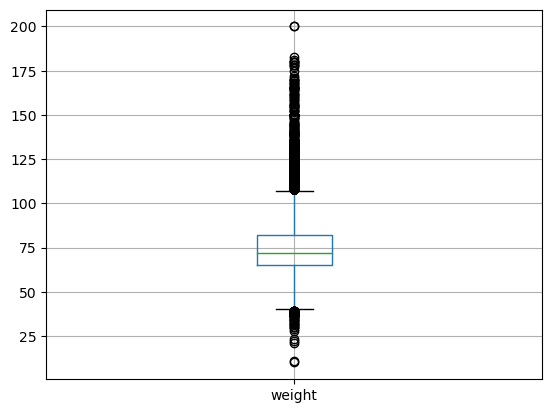

In [98]:
cardio1_df.boxplot(column='weight')

<AxesSubplot: >

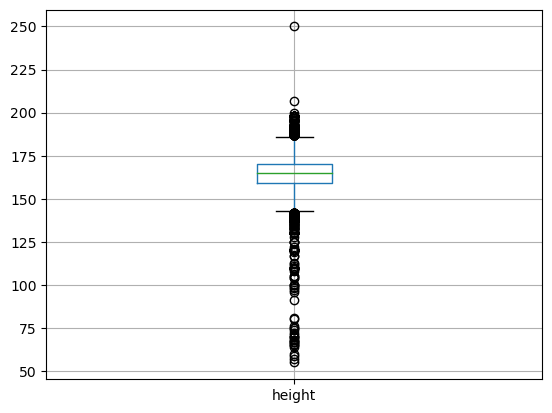

In [99]:
cardio1_df.boxplot(column='height')

<AxesSubplot: >

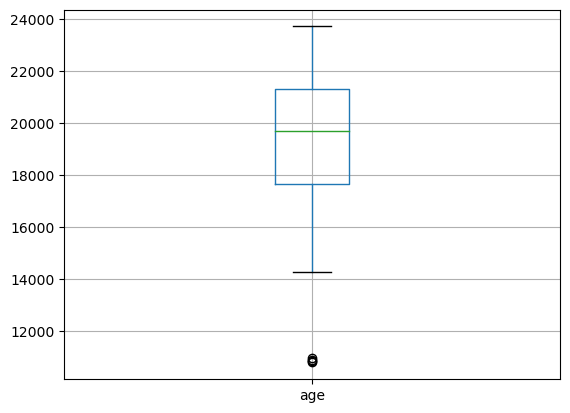

In [100]:
cardio1_df.boxplot(column='age')

In [101]:
clean_cdf = cardio1_df[cardio1_df['ap_hi'] < 250]
clean_cdf = clean_cdf[clean_cdf['ap_lo'] < 250]
clean_cdf = clean_cdf[clean_cdf['height'] < 210]

<AxesSubplot: >

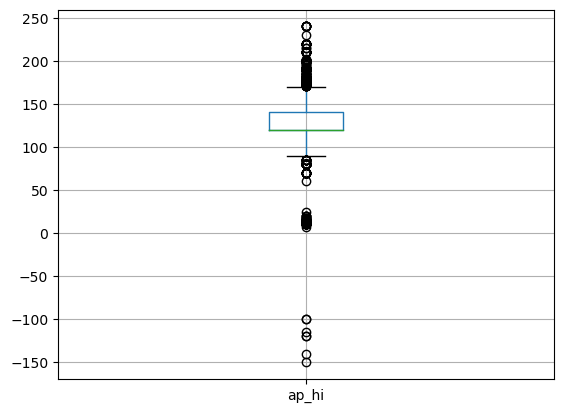

In [102]:
clean_cdf.boxplot(column='ap_hi')

<AxesSubplot: >

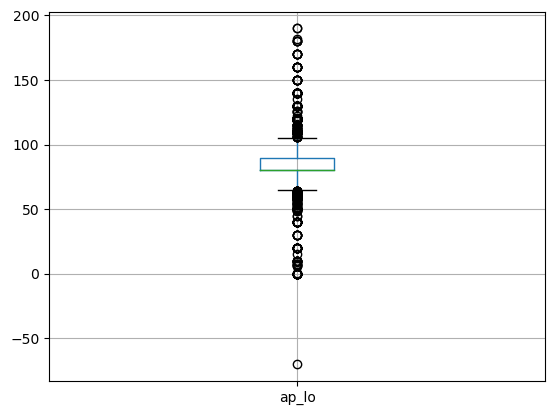

In [103]:
clean_cdf.boxplot(column='ap_lo')

<AxesSubplot: >

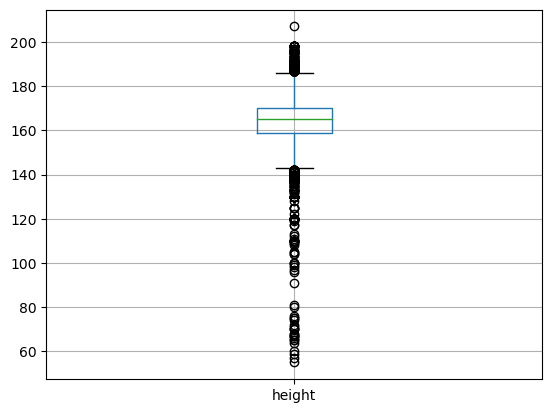

In [104]:
clean_cdf.boxplot(column='height')

In [105]:
clean_cdf['gender'] -= 1
print(clean_cdf.head())

   id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0  18393       1   168.0    62.0    110     80          1.0     1      0   
1   1  20228       0   156.0    85.0    140     90          3.0     1      0   
2   2  18857       0   165.0    64.0    130     70          3.0     1      0   
3   3  17623       1   169.0    82.0    150    100          1.0     1      0   
4   4  17474       0   156.0    56.0    100     60          1.0     1      0   

   alco  active  cardio  
0   0.0       1       0  
1   0.0       1       1  
2   0.0       0       1  
3   0.0       1       1  
4   0.0       0       0  


In [106]:
X = clean_cdf.drop('cardio' , axis= 1)
y = clean_cdf['cardio']

X_train , X_test , y_train , y_test = train_test_split(X , y , test_size=0.2 , random_state= 42)


In [107]:
pipeline_mms_lr = Pipeline([
                            ('min_max_scaler', MinMaxScaler()),
                            ('logistic_regression', LogisticRegression())
                            ])
pipeline_ss_lr = Pipeline([
                            ('standard_scaler', StandardScaler()),
                            ('logistic_regression', LogisticRegression())
                        ])
pipeline_mm_gradient = Pipeline([('min_max_scaler' , MinMaxScaler()), ('gradient_boosting_classifier', GradientBoostingClassifier())])

pipeline_ss_gradient = Pipeline([('standard_scaler' , StandardScaler()), ('gradient_boosting_classifier', GradientBoostingClassifier())])

pipeline_mm_svc = Pipeline([('min_max_scaler' , MinMaxScaler()), ('svc' , SVC())])

pipeline_ss_svc = Pipeline([('standard_scaler' , StandardScaler()), ('svc', SVC())])

pipeline_mm_rf = Pipeline([('min_max_scaler' , MinMaxScaler()), ('random_forest_classifier', RandomForestClassifier())])

pipeline_ss_rf = Pipeline([('standard_scaler' , StandardScaler()), ('random_forest_classifier', RandomForestClassifier())])






In [108]:
pipelines = [pipeline_mms_lr, pipeline_ss_lr, pipeline_mm_gradient, pipeline_ss_gradient, pipeline_mm_svc, pipeline_ss_svc, pipeline_mm_rf, pipeline_ss_rf]

for pipe in pipelines:
    pipe.fit(X_train , y_train)
    
    
pipe_dict = {}
best_score = 0

model_name = ['MMS + LogisticRegression' , 'SS + LogisticRegression', 'MMS + GradientBoostingClassifier' , 'SS + GradientBoostingClassifier', 'MMS + SVC', 'SS + SVC' , 'MMS + RandomForestClassifier', 'SS + RandomForestClassifier']


for i, model in enumerate(pipelines):
    y_pred = model.predict(X_test)
    
    pipe_dict[model_name[i]] = [accuracy_score(y_test , y_pred), f1_score(y_test, y_pred , average = 'weighted')]
    
    if model.score(X_test , y_test) > best_score:
        best_score = model.score(X_test , y_test)
        best_pipeline = model_name[i]
        
        
print('the best model for heart attack prediction is {} with the accuracy of {}'.format(best_pipeline, best_score))


the best model for heart attack prediction is SS + GradientBoostingClassifier with the accuracy of 0.7366666666666667


In [109]:
model_comparison_df = pd.DataFrame.from_dict(pipe_dict).T
model_comparison_df.columns = ['Accuracy' , 'F1 Score']
model_comparison_df = model_comparison_df.sort_values('Accuracy', ascending=False)
model_comparison_df.style.background_gradient(cmap='GnBu') 

,Accuracy,F1 Score
SS + GradientBoostingClassifier,0.736667,0.736092
MMS + GradientBoostingClassifier,0.736594,0.736021
SS + SVC,0.732464,0.731331
MMS + SVC,0.729565,0.728609
SS + LogisticRegression,0.726449,0.725541
MMS + LogisticRegression,0.726087,0.725275
MMS + RandomForestClassifier,0.722174,0.721877
SS + RandomForestClassifier,0.719783,0.719471


In [110]:
pipeline_ss_gradient.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standard_scaler', 'gradient_boosting_classifier', 'standard_scaler__copy', 'standard_scaler__with_mean', 'standard_scaler__with_std', 'gradient_boosting_classifier__ccp_alpha', 'gradient_boosting_classifier__criterion', 'gradient_boosting_classifier__init', 'gradient_boosting_classifier__learning_rate', 'gradient_boosting_classifier__loss', 'gradient_boosting_classifier__max_depth', 'gradient_boosting_classifier__max_features', 'gradient_boosting_classifier__max_leaf_nodes', 'gradient_boosting_classifier__min_impurity_decrease', 'gradient_boosting_classifier__min_samples_leaf', 'gradient_boosting_classifier__min_samples_split', 'gradient_boosting_classifier__min_weight_fraction_leaf', 'gradient_boosting_classifier__n_estimators', 'gradient_boosting_classifier__n_iter_no_change', 'gradient_boosting_classifier__random_state', 'gradient_boosting_classifier__subsample', 'gradient_boosting_classifier__tol', 'gradient_boosting_classifier__validation_

In [118]:
#the values used are only 1 because it takes too long to run
grid_param = [{'gradient_boosting_classifier__learning_rate': [ 0.2],
               'gradient_boosting_classifier__n_estimators': [1000],
               'gradient_boosting_classifier__max_depth':[2],
               'gradient_boosting_classifier__min_samples_split':[20],
               'gradient_boosting_classifier__min_samples_leaf':[20],
               'gradient_boosting_classifier__subsample':[0.8]}]

grid_search = GridSearchCV(pipeline_ss_gradient, grid_param, cv =5 , verbose=1, n_jobs=1)

grid = grid_search.fit(X_train , y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [119]:
print(grid_search.score(X_test, y_test))

0.7323913043478261


### model evaluation

In [120]:
y_pred = grid.predict(X_test)

labels = ['No Cardiovascular Disease', 'Has Cardiovascular Disease']
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test ,y_pred, target_names=labels)

In [121]:
print(cr)

                            precision    recall  f1-score   support

 No Cardiovascular Disease       0.72      0.77      0.75      7031
Has Cardiovascular Disease       0.74      0.69      0.72      6769

                  accuracy                           0.73     13800
                 macro avg       0.73      0.73      0.73     13800
              weighted avg       0.73      0.73      0.73     13800



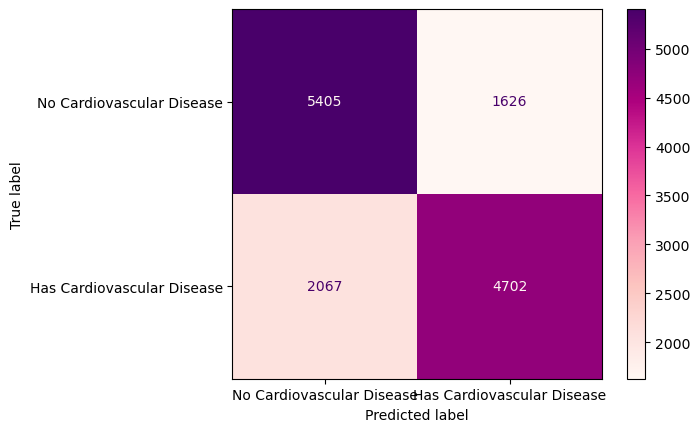

In [122]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm , display_labels=labels)
disp.plot(cmap='RdPu')
plt.rcParams['figure.figsize'] = [6,6]
plt.show()

### model saving

In [123]:
MODEL_PATH = os.path.join(  'cardio_model.pkl')

with open(MODEL_PATH, 'wb') as file:
    pickle.dump(grid.best_estimator_, file)

### load test case

In [133]:
# load the test set
test_set = pd.read_csv('test_set.csv' ,sep=';')
test_set.columns
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           5 non-null      int64  
 1   age          5 non-null      int64  
 2   gender       5 non-null      int64  
 3   height       5 non-null      int64  
 4   weight       5 non-null      float64
 5   ap_hi        5 non-null      int64  
 6   ap_lo        5 non-null      int64  
 7   cholesterol  5 non-null      int64  
 8   gluc         5 non-null      int64  
 9   smoke        5 non-null      int64  
 10  alco         5 non-null      int64  
 11  active       5 non-null      int64  
 12  cardio       5 non-null      int64  
dtypes: float64(1), int64(12)
memory usage: 648.0 bytes


In [138]:
Xt=test_set.drop(['cardio'], axis=1)
yt= test_set['cardio']
Xt_train,Xt_test, yt_train, yt_test = train_test_split(Xt, yt, test_size= 0.2, random_state= 42)

In [145]:
y_pred= grid.predict(Xt_test)


cm = confusion_matrix(yt_test, y_pred)
cr = classification_report(yt_test ,y_pred)


In [146]:
print(cr)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1

